参数高效微调

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
!ls sst2

data  README.md


In [4]:
!pip install datasets==2.20.0

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.5.0 which is incompatible.
torch 2.5.1

In [5]:
!pip list|grep datasets

datasets                           2.20.0
tensorflow-datasets                4.9.7
vega-datasets                      0.9.0


In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig, AutoModel, get_cosine_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from tqdm.auto import tqdm

# 固定seed
torch.manual_seed(42)
# 确定设备：如果有GPU可用则使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#如果GPU可以，可以改为20
num_epochs = 5
patience = 5

training_record = {}

## preparation

SST-2（Stanford Sentiment Treebank）是斯坦福大学发布的一个用于情感分析的数据集，旨在对句子的情感进行分类。该数据集中包含电影评论句子，每个句子都带有相应的情感标签。情感标签分为两类：正面（positive）和负面（negative），因此 SST-2 是一个二分类任务的数据集。

Positive（正面）：

"The movie was absolutely fantastic."（这部电影绝对太棒了。）
"I loved the acting and the storyline."（我喜欢演技和故事情节。）

Negative（负面）：

"The film was a complete disaster."（这部电影完全是个灾难。）
"The acting was terrible, I wouldn't recommend it."（演技糟糕，我不推荐这部电影。）

### load dataset

In [7]:
# https://huggingface.co/google-bert/bert-base-uncased
# tokenizer，加载bert的分词器,uncased就是不区分大小写
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# dataset
dataset_sst2 = load_dataset(
    "parquet",
    data_files={
        "train": "./sst2/data/train-00000-of-00001.parquet",
        "validation": "./sst2/data/validation-00000-of-00001.parquet"
        })

# preprocessing
def collate_fn(batch):
    #对字符串文本，进行编码，变为id
    inputs = tokenizer([x["sentence"] for x in batch], padding="longest", truncation=True, return_tensors="pt", max_length=512)
    labels = torch.tensor([x["label"] for x in batch])
    return inputs, labels

train_loader = DataLoader(dataset_sst2["train"], batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset_sst2["validation"], batch_size=32, collate_fn=collate_fn)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [8]:
# 遍历 DataLoader 中的一个批次示例
for batch in train_loader:
    print(batch)
    break

({'input_ids': tensor([[ 101, 2062, 8669,  ...,    0,    0,    0],
        [ 101, 2009, 1005,  ...,    0,    0,    0],
        [ 101, 2003, 1037,  ..., 5541, 2143,  102],
        ...,
        [ 101, 2980,  102,  ...,    0,    0,    0],
        [ 101, 2032, 2000,  ...,    0,    0,    0],
        [ 101, 2008, 2573,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}, tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1]))


### define evaluattion and training function

In [9]:
def evaluate(model, val_loader):
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():# 在评估过程中关闭梯度计算
        total_samples = 0
        for inputs, labels in val_loader:
            inputs = {k: v.to(device) for k, v in inputs.items()} #输入是一个字典，所以拿value
            labels = labels.to(device)
            probs = model(**inputs)
            loss = F.binary_cross_entropy(probs, labels.float())
            val_loss += loss.item()
            val_acc += ((probs > 0.5) == labels).sum().item() #模型的预测结果与实际标签是否相等,求和得到预测正确数量
            total_samples += len(labels)

    val_loss /= len(val_loader)
    val_acc /= total_samples
    return val_loss, val_acc


def train(model, train_loader, val_loader, device, num_epochs=3, patience=3):
    # 将模型移动到指定设备
    model.to(device)

    # 定义优化器
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    # 计算训练步数总数
    total_steps = num_epochs * len(train_loader)

    # 使用transformers库中的余弦学习率调度器进行学习率调整
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.2 * total_steps), #前20%步，学习率提升
        num_training_steps=total_steps
    )

    # 提前停止训练的控制变量
    best_val_acc = -1
    cur = 0

    # 存储训练和验证指标的容器
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # 进入训练模式
        model.train()
        train_loss = 0
        train_acc = 0
        total_samples = 0

        # 对训练数据进行迭代
        for inputs, labels in tqdm(train_loader):
            # 将数据移动到指定设备
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            # 前向传播并计算损失
            optimizer.zero_grad()
            probs = model(**inputs)
            loss = F.binary_cross_entropy(probs, labels.float())
            loss.backward()
            optimizer.step()
            scheduler.step()

            # 收集指标
            train_loss += loss.item()
            train_acc += ((probs > 0.5) == labels).sum().item()
            total_samples += len(labels)

        train_loss /= len(train_loader)
        train_acc  /= total_samples

        # 进行验证
        val_loss, val_acc = evaluate(model, val_loader)

        # 记录指标
        print(f"epoch {epoch}: train_loss {train_loss:.4f}, train_acc {train_acc:.4f}, val_loss {val_loss:.4f}, val_acc {val_acc:.4f}")
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # 提前停止训练
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            cur = 0
        else:
            cur += 1
        if cur >= patience:
            print("提前停止训练")
            break

    return history

### a function to check the parameters that could be fintuned

In [10]:
def human_readable_count(n):
    # 定义一个函数，用于处理可读性较好的数字格式
    if n < 1_000:
        return f"{n}"
    elif n < 1_000_000:
        return f"{n/1_000:.2f}K"  # 如果在千到百万之间，使用K表示
    elif n < 1_000_000_000:
        return f"{n/1_000_000:.2f}M"  # 如果在百万到十亿之间，使用M表示
    else:
        return f"{n/1_000_000_000:.2f}B"  # 如果大于十亿，使用B表示


def count_parameters(model):
    # 统计模型参数
    total_params = sum(p.numel() for p in model.parameters())  # 总参数数量
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # 可训练参数数量
    frozen_params = total_params - trainable_params  # 冻结参数数量

    # 输出参数数量
    print(f"Total Parameters:\t{human_readable_count(total_params):>8}")  # 输出总参数数量（格式化为可读性更好的格式）
    print(f"Frozen Parameters:\t{human_readable_count(frozen_params):>8}")  # 输出冻结参数数量（格式化为可读性更好的格式）
    print(f"Trainable Parameters:\t{human_readable_count(trainable_params):>8}\t{trainable_params / total_params:.2%}")  # 输出可训练参数数量以及所占比例

In [11]:
import matplotlib.pyplot as plt  # 导入绘图库

def plot_training_record(training_record, metric_name="val_acc"):
    """
    绘制训练记录图表

    参数:
    training_record(dict): 包含训练记录的字典，键为方法名称，值为记录的字典
    metric_name(str): 要绘制的度量名称，默认为"val_acc"（验证准确度）

    返回:
    无（直接展示图表）
    """
    plt.figure(figsize=(12, 6))  # 设置图表大小
    for method_name, record in training_record.items():  # 遍历每个方法的记录
        metrics = record[metric_name]  # 获取指定度量的数值
        plt.plot(range(len(metrics)), metrics, label=method_name)  # 绘制折线图

    plt.xlabel("Epoch")  # 设置X轴标签
    plt.ylabel("Validation Accuracy")  # 设置Y轴标签
    plt.legend()  # 显示图例
    plt.grid()  # 显示网格线
    plt.show()  # 展示图表

## A Frozen pretrained Bert as a feature extractor  将预训练过的Bert冻结作为特征提取器

In [12]:
# https://huggingface.co/docs/transformers/model_doc/bert 官网帮助
# 定义一个继承自 nn.Module 的 FrozenBert 类
class FrozenBert(nn.Module):
    def __init__(self):
      super().__init__()
      # 加载预训练的BERT模型（不区分大小写的版本），因为下载模型，需要等待一下
      self.model = AutoModel.from_pretrained("bert-base-uncased")

      # 添加一个线性分类器，其输入尺寸是BERT模型的隐藏层尺寸，输出是1
      self.classifier = nn.Linear(self.model.config.hidden_size, 1)

      # 冻结BERT模型的所有参数，这样在训练过程中它们不会被更新
      for param in self.model.parameters():
          param.requires_grad = False

    # 定义前向传播过程
    def forward(self, **inputs):
      # 获取BERT的最后一个隐藏层的输出，并选中序列的第一项（[CLS] token）,肯定不可以选最后一个，可以尝试平均
      feature = self.model(**inputs).last_hidden_state[:, 0, :]
      # 将特征通过线性分类器获取对数几率
      logits = self.classifier(feature)
      # 应用sigmoid激活函数并将结果集中成一维输出
      return torch.sigmoid(logits).squeeze()


# 实例化FrozenBert类，创建一个模型对象
frozen_bert = FrozenBert()
print(frozen_bert)
# for name, param in frozen_bert.named_parameters(): # 打印模型参数
#   print(name, param.shape)
# 定义一个函数（此函数未在代码中提供），用来计算模型的参数数量
count_parameters(frozen_bert)

# training_record一个训练记录字典，来记录不同训练阶段的信息，在最上面进行的初始化



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

FrozenBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [13]:
!ls /root/.cache/huggingface/hub/models--bert-base-uncased/

blobs  refs  snapshots


In [14]:
# 调用train函数来训练模型，传递模型对象、训练数据加载器、验证数据加载器、
# 使用设备、训练迭代次数和早停耐心值（这些变量在代码中没有定义）
training_record["Frozen"] = train(frozen_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.6774, train_acc 0.5716, val_loss 0.6723, val_acc 0.5206


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.6436, train_acc 0.6253, val_loss 0.6238, val_acc 0.6571


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 2: train_loss 0.6140, train_acc 0.7043, val_loss 0.5940, val_acc 0.7626


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 3: train_loss 0.5984, train_acc 0.7346, val_loss 0.5816, val_acc 0.7867


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 4: train_loss 0.5936, train_acc 0.7469, val_loss 0.5797, val_acc 0.7924


In [15]:
training_record

{'Frozen': {'train_loss': [0.6774013442834595,
   0.6435645660142151,
   0.6140088986614255,
   0.598374310057973,
   0.5936110704358569],
  'train_acc': [0.5715600825550491,
   0.6253396486956005,
   0.7043163224398283,
   0.7345766084128941,
   0.7469450177433964],
  'val_loss': [0.672339413847242,
   0.623795707310949,
   0.5940487469945636,
   0.5816210742507663,
   0.5797192475625447],
  'val_acc': [0.5206422018348624,
   0.6571100917431193,
   0.7626146788990825,
   0.786697247706422,
   0.7924311926605505]}}

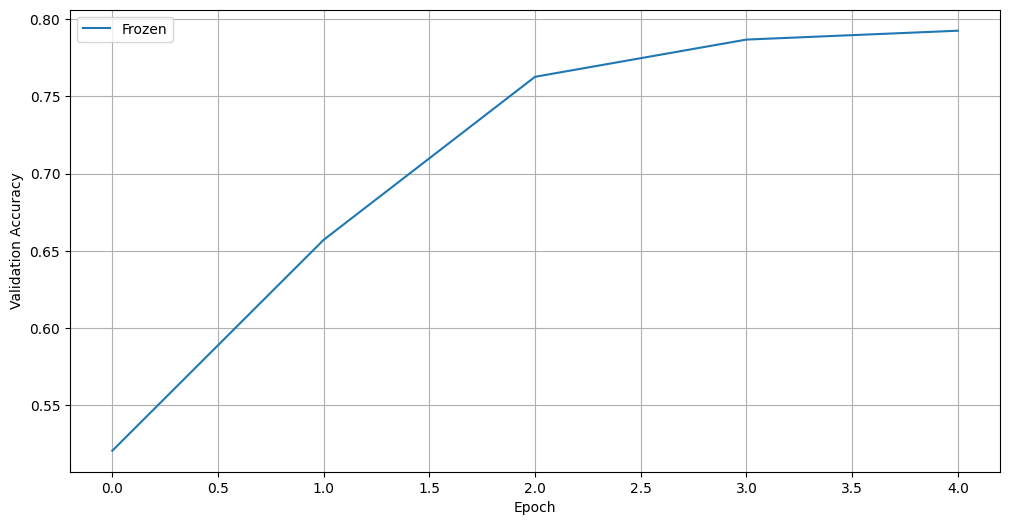

In [16]:
plot_training_record(training_record, metric_name="val_acc")

## Fully Finetuning

In [17]:
class FullyFinetunedBert(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = AutoModel.from_pretrained("bert-base-uncased")  # 从预训练模型加载BERT
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)  # 添加线性分类器，输出维度为1

    def forward(self, **inputs):
        feature = self.model(**inputs).last_hidden_state[:, 0, :]  # 获取特征向量
        logits = self.classifier(feature)  # 应用分类器
        return torch.sigmoid(logits).squeeze()  # 使用sigmoid激活函数并压缩维度


# 加载预训练模型
fully_fine_tuned_bert = FullyFinetunedBert()
print('-'*50)
print(fully_fine_tuned_bert)
print('-'*50)
# 检查参数数量
count_parameters(fully_fine_tuned_bert)

# 训练
training_record["Fully Fine-Tuning"] = train(
    fully_fine_tuned_bert,
    train_loader,
    val_loader,
    device,
    num_epochs=num_epochs,
    patience=patience
    )  # 对完全微调的BERT进行训练，并将训练记录保存在training_record中

--------------------------------------------------
FullyFinetunedBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
          

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.3013, train_acc 0.8638, val_loss 0.2987, val_acc 0.9002


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.1453, train_acc 0.9470, val_loss 0.2322, val_acc 0.9106


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 2: train_loss 0.0924, train_acc 0.9684, val_loss 0.2351, val_acc 0.9197


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 3: train_loss 0.0620, train_acc 0.9793, val_loss 0.2686, val_acc 0.9209


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 4: train_loss 0.0457, train_acc 0.9843, val_loss 0.2877, val_acc 0.9243


In [18]:
del fully_fine_tuned_bert

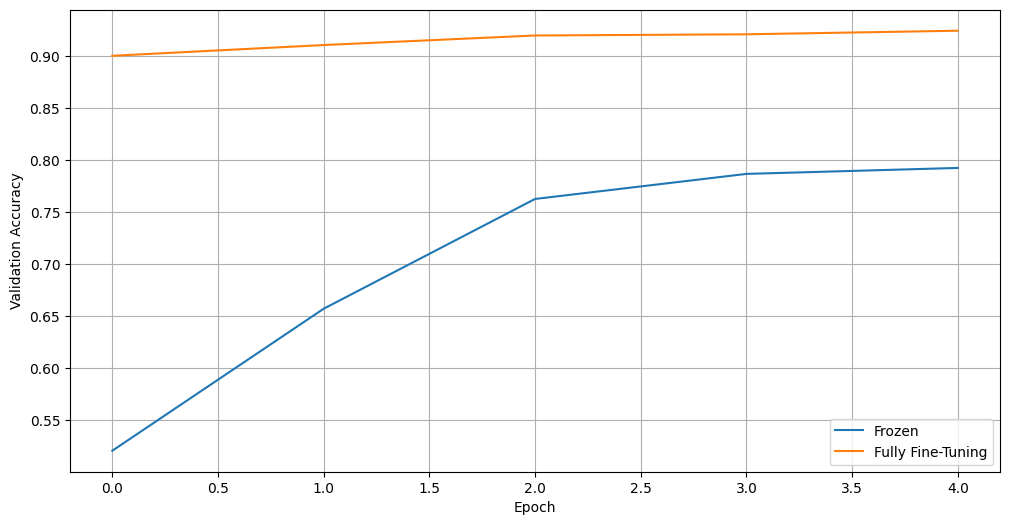

In [19]:
#可以看到全量微调的效果非常好
plot_training_record(training_record, metric_name="val_acc")

## BitFit

BitFit（论文：BitFit: Simple Parameter-efficient Fine-tuning or Transformer-based Masked Language-models）是一种稀疏的微调方法，它训练时只更新bias的参数或者部分bias参数。

In [20]:
class BitFitBert(nn.Module):
    def __init__(self):
        super().__init__()
        # 加载预训练模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

        # 冻结除所有偏置项之外的参数
        for name, param in self.model.named_parameters():
            if "bias" not in name:
                param.requires_grad = False

    def forward(self, **inputs):
        feature = self.model(**inputs).last_hidden_state[:, 0, :]  # 获取特征向量
        logits = self.classifier(feature)  # 应用分类器
        return torch.sigmoid(logits).squeeze()  # 使用sigmoid激活函数并压缩维度


# 加载预训练模型
bitfit_bert = BitFitBert()
print('-'*50)
print(bitfit_bert)
print('-'*50)
# 检查参数数量
count_parameters(bitfit_bert)

# 训练
training_record["BitFit"] = train(bitfit_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)  # 对BitFitBert进行训练，并将训练记录保存在training_record中

--------------------------------------------------
BitFitBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.6630, train_acc 0.6010, val_loss 0.5340, val_acc 0.8303


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.3862, train_acc 0.8494, val_loss 0.3391, val_acc 0.8578


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 2: train_loss 0.3321, train_acc 0.8625, val_loss 0.3202, val_acc 0.8647


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 3: train_loss 0.3196, train_acc 0.8672, val_loss 0.3133, val_acc 0.8658


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 4: train_loss 0.3194, train_acc 0.8675, val_loss 0.3118, val_acc 0.8647


In [ ]:
del bitfit_bert

In [ ]:
#偏置项冻结后效果变差了一些
plot_training_record(training_record, metric_name="val_acc")

## P-Tuning & P-Tuning v2 & Prefix Tuning

Prefix Tuning（论文：Prefix-Tuning: Optimizing Continuous Prompts for Generation），在输入token之前构造一段任务相关的virtual tokens作为Prefix，然后训练的时候只更新Prefix部分的参数，而PLM中的其他部分参数固定。

* 针对不同的模型结构，需要构造不同的Prefix。
    * 针对自回归架构模型：在句子前面添加前缀，得到 z = [PREFIX; x; y]，合适的上文能够在固定 LM 的情况下去引导生成下文（比如：GPT3的上下文学习）。
    * 针对编码器-解码器架构模型：Encoder和Decoder都增加了前缀，得到 z = [PREFIX; x; PREFIX0; y]。Encoder端增加前缀是为了引导输入部分的编码，Decoder 端增加前缀是为了引导后续token的生成。


P-Tuning（论文：GPT Understands, Too），该方法将Prompt转换为可以学习的Embedding层，并用MLP+LSTM的方式来对Prompt Embedding进行一层处理。

相比Prefix Tuning，P-Tuning加入的可微的virtual token，但仅限于输入层，没有在每一层都加；另外，virtual token的位置也不一定是前缀，插入的位置是可选的。这里的出发点实际是把传统人工设计模版中的真实token替换成可微的virtual token。

P-Tuning v2（论文： P-Tuning v2: Prompt Tuning Can Be Comparable to Fine-tuning Universally Across Scales and Tasks），该方法在每一层都加入了Prompts tokens作为输入，而不是仅仅加在输入层，这带来两个方面的好处：

更多可学习的参数（从P-tuning和Prompt Tuning的0.01%增加到0.1%-3%），同时也足够参数高效。
加入到更深层结构中的Prompt能给模型预测带来更直接的影响。


自然语言生成 (NLG) 和 自然语言理解 (NLU)
### 区别

|方法|参数重整化| 微调参数所在层 | 适配下游任务 |
|-|-|-|-|
|P-tuning|MLP + LSTM 或者 MLP| embedding 层| 使得GPT做NLU |
|P-tuning v2|不使用| 每一层 | NLG & NLU |
|prefix tuning|MLP| 每一层 | NLG |

In [ ]:
import torch
import torch.nn as nn
prefix_tokens = nn.Parameter(torch.zeros(20, 768))
prefix_tokens = prefix_tokens.unsqueeze(0).expand(32, -1, -1) #给每个样本都增加一个（20, 768）
print(prefix_tokens.shape)

In [24]:
import torch
import torch.nn as nn
from transformers import AutoModel
import torch.nn.functional as F
import numpy as np

class PTuningBert(nn.Module):
    def __init__(self, num_virtual_tokens=20, reparameterization_type="MLP"):
        super().__init__()
        # 加载预训练模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

        # 冻结除分类器层之外的参数
        for param in self.model.parameters():
            param.requires_grad = False

        hidden_size = self.model.config.hidden_size
        self.num_virtual_tokens = num_virtual_tokens
        # 定义一个可学习的参数，作为虚拟提示的初始值，其形状为(num_virtual_tokens, hidden_size)
        self.prompt = nn.Parameter(torch.zeros(self.num_virtual_tokens, hidden_size))
        print(self.prompt.shape)
        # 重新参数化,根据传入的reparameterization_type参数，初始化不同的重新参数化头部
        self.reparameterization_type = reparameterization_type
        if reparameterization_type == "MLP":
            self.mlp_head = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
            )
        elif reparameterization_type == "LSTM":
            self.lstm_head = nn.LSTM(
                input_size=hidden_size,
                hidden_size=hidden_size,
                num_layers=2,
                bidirectional=True,
                batch_first=True,
            )
            self.mlp_head = nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size * 2),
                nn.ReLU(),
                nn.Linear(hidden_size * 2, hidden_size),
            )

    def forward(self, input_ids, attention_mask, **args):
        # 获取输入的批次大小
        batch_size = input_ids.size(0)
        # 将虚拟提示扩展到与输入相同批次大小
        prompt = self.prompt.unsqueeze(0).expand(batch_size, -1, -1)

        # 根据选择的重新参数化类型，对虚拟提示进行处理
        if self.reparameterization_type == "MLP":
            prompt = self.mlp_head(prompt)
        elif self.reparameterization_type == "LSTM":
            prompt, _ = self.lstm_head(prompt)
            prompt = self.mlp_head(prompt)

        # 将虚拟提示与输入的嵌入层输出连接，形成扩展的输入嵌入
        embedding_output = self.model.embeddings(input_ids)
        extended_inputs_embeds = torch.cat([prompt, embedding_output], dim=1) #在seq_len进行拼接
        extended_attention_mask = torch.cat([
            torch.ones(batch_size, self.num_virtual_tokens).to(input_ids.device),
            attention_mask
        ], dim=1)

        #将扩展的输入嵌入和注意力掩码输入BERT模型
        outputs = self.model(inputs_embeds=extended_inputs_embeds, attention_mask=extended_attention_mask)
        # 获取经过BERT模型处理后的特定位置的特征，即虚拟提示之后的第一个位置，等价于原来的第0个位置
        feature = outputs.last_hidden_state[:, self.num_virtual_tokens, :]

        logits = self.classifier(feature)
        return torch.sigmoid(logits).squeeze()


# 加载预训练模型
ptuning_bert = PTuningBert()
print('-'*50)
print(ptuning_bert)
print('-'*50)
# 记录参数数量
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(ptuning_bert)

torch.Size([20, 768])
--------------------------------------------------
PTuningBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=T

In [25]:
for idx, (key, value) in enumerate(ptuning_bert.named_parameters()):
  print(f'key:{key}--value:{value.shape}')

key:prompt--value:torch.Size([20, 768])
key:model.embeddings.word_embeddings.weight--value:torch.Size([30522, 768])
key:model.embeddings.position_embeddings.weight--value:torch.Size([512, 768])
key:model.embeddings.token_type_embeddings.weight--value:torch.Size([2, 768])
key:model.embeddings.LayerNorm.weight--value:torch.Size([768])
key:model.embeddings.LayerNorm.bias--value:torch.Size([768])
key:model.encoder.layer.0.attention.self.query.weight--value:torch.Size([768, 768])
key:model.encoder.layer.0.attention.self.query.bias--value:torch.Size([768])
key:model.encoder.layer.0.attention.self.key.weight--value:torch.Size([768, 768])
key:model.encoder.layer.0.attention.self.key.bias--value:torch.Size([768])
key:model.encoder.layer.0.attention.self.value.weight--value:torch.Size([768, 768])
key:model.encoder.layer.0.attention.self.value.bias--value:torch.Size([768])
key:model.encoder.layer.0.attention.output.dense.weight--value:torch.Size([768, 768])
key:model.encoder.layer.0.attention.out

In [26]:
# 进行训练
training_record["P-Tuning"] = train(ptuning_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.6632, train_acc 0.5965, val_loss 0.6272, val_acc 0.6560


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.5543, train_acc 0.7223, val_loss 0.5352, val_acc 0.7328


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 2: train_loss 0.5050, train_acc 0.7573, val_loss 0.4879, val_acc 0.7661


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 3: train_loss 0.4871, train_acc 0.7668, val_loss 0.4831, val_acc 0.7592


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 4: train_loss 0.4806, train_acc 0.7728, val_loss 0.4802, val_acc 0.7603


In [ ]:
del ptuning_bert

In [ ]:
plot_training_record(training_record, metric_name="val_acc")

In [ ]:
# 定义一个继承自nn.Module的类，用于前缀调优的BERT模型
class PrefixTuningBert(nn.Module):
    def __init__(self, num_virtual_tokens=20, prefix_projection=True):
        super().__init__()  # 调用父类的初始化方法
        # 加载预训练的BERT模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        # 添加一个线性分类层
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

        # 冻结预训练模型的参数，只训练分类器层
        for param in self.model.parameters():
            param.requires_grad = False

        # 前缀相关的参数
        self.num_virtual_tokens = num_virtual_tokens  # 虚拟token的数量
        self.prefix_projection = prefix_projection  # 是否使用前缀投影
        hidden_size = self.model.config.hidden_size  # 隐藏层大小
        self.num_layers = self.model.config.num_hidden_layers  # Transformer层数
        self.num_attention_heads = self.model.config.num_attention_heads  # 注意力头数
        self.embed_size_per_head = hidden_size // self.num_attention_heads  # 每个头的嵌入大小

        # 如果使用前缀投影
        if self.prefix_projection:
            # 使用两层MLP来编码前缀token
            self.prefix_tokens = nn.Parameter(torch.zeros(self.num_virtual_tokens, hidden_size))
            self.transform = torch.nn.Sequential(
                torch.nn.Linear(hidden_size, hidden_size),  # 第一层MLP
                torch.nn.Tanh(),  # 使用tanh激活函数
                torch.nn.Linear(hidden_size, self.num_layers * 2 * hidden_size),  # 第二层MLP
            )
        else:
            # 不使用前缀投影，直接使用token
            self.prefix_tokens = nn.Parameter(torch.zeros(self.num_virtual_tokens, hidden_size))

    def forward(self, input_ids, attention_mask, **args):
        # 将前缀token投影并分割为key和value
        batch_size = input_ids.size(0) #获得批次大小
        prefix_tokens = self.prefix_tokens.unsqueeze(0).expand(batch_size, -1, -1)
        if self.prefix_projection:
            past_key_values = self.transform(prefix_tokens) #输出的形状为(batch_size, 20, self.num_layers * 2 * hidden_size)
        else:
            past_key_values = prefix_tokens

        # 改变形状以适配Transformer的输入格式
        # print(past_key_values.shape)
        #(batch_size, self.num_layers, 2, self.num_attention_heads, -1, self.embed_size_per_head)
        past_key_values = past_key_values.view(batch_size, self.num_layers, 2, self.num_attention_heads, -1, self.embed_size_per_head)
        # print(past_key_values.shape) #shape值为torch.Size([32, 12, 2, 12, 20, 64])
        # 重新排列维度以适配Transformer的输入格式
        #(2，self.num_layers,batch_size, self.num_attention_heads, -1, self.embed_size_per_head)
        past_key_values = past_key_values.permute(2, 1, 0, 3, 4, 5)
        # 分离成多个包含key和value的元组，每个元组对应一层Transformer
        past_key_values = tuple([tuple([past_key_values[0][i], past_key_values[1][i]]) for i in range(self.num_layers)])
        # for k,v in past_key_values:
        #   print(f'k.shape{k.shape}')  #torch.Size([32, 12, 20, 64])
        #   print(f'v.shape{k.shape}')  #torch.Size([32, 12, 20, 64])
        # 修改注意力掩码，包含前缀token
        extended_attention_mask = torch.cat([
            torch.ones(batch_size, self.num_virtual_tokens).to(attention_mask.device),  # 前缀的注意力掩码
            attention_mask
            ], dim=1)

        # 将数据输入到BERT模型中
        outputs = self.model(input_ids, extended_attention_mask, past_key_values=past_key_values)

        feature = outputs.last_hidden_state[:, 0, :]  # 获取[CLS] token的特征表示

        # 使用分类层进行分类
        logits = self.classifier(feature)

        # 返回sigmoid激活后的logits
        return torch.sigmoid(logits).squeeze()

# 创建前缀调优BERT模型实例
prefix_tuning_bert = PrefixTuningBert()
# print(prefix_tuning_bert)
# 计算模型参数数量
count_parameters(prefix_tuning_bert)



In [ ]:
768*12*2 #2代表key和value

In [ ]:
12*64

In [ ]:
# 训练模型，这里的train函数和train_loader、val_loader等变量需要在其他地方定义
# num_epochs和patience变量也需要在其他地方定义
training_record["Prefix Tuning"] = train(prefix_tuning_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)

In [33]:
del prefix_tuning_bert

In [ ]:
# !cp -r ~/.cache/huggingface/hub/models--bert-base-uncased .

In [ ]:
!pwd

In [ ]:
plot_training_record(training_record, metric_name="val_acc")

In [37]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class PTuningV2Bert(nn.Module):
    def __init__(self, num_virtual_tokens=20, prefix_projection=True):
        super().__init__()
        # 加载预训练的BERT模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        # 添加一个线性分类层
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

        # 冻结预训练模型的参数，只训练分类器层
        for param in self.model.parameters():
            param.requires_grad = False

        # 前缀相关的参数
        self.num_virtual_tokens = num_virtual_tokens
        self.prefix_projection = prefix_projection
        hidden_size = self.model.config.hidden_size
        self.num_layers = self.model.config.num_hidden_layers
        self.num_attention_heads = self.model.config.num_attention_heads
        self.embed_size_per_head = hidden_size // self.num_attention_heads

        # P-Tuning v2 的前缀嵌入
        self.prefix_embeddings = nn.Embedding(self.num_virtual_tokens, hidden_size)
        nn.init.uniform_(self.prefix_embeddings.weight, -0.1, 0.1)

        if self.prefix_projection:
            # 使用两层MLP来编码前缀token
            self.prefix_projection_layer = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, self.num_layers * 2 * hidden_size)
            )

    def forward(self, input_ids, attention_mask, **args):
        batch_size = input_ids.size(0)
        prefix_tokens = torch.arange(self.num_virtual_tokens, device=input_ids.device).unsqueeze(0).expand(batch_size, -1)
        prefix_embeddings = self.prefix_embeddings(prefix_tokens)

        if self.prefix_projection:
            past_key_values = self.prefix_projection_layer(prefix_embeddings)
        else:
            past_key_values = prefix_embeddings

        # 改变形状以适配Transformer的输入格式
        past_key_values = past_key_values.view(batch_size, self.num_layers, 2, self.num_attention_heads, -1, self.embed_size_per_head)
        past_key_values = past_key_values.permute(2, 1, 0, 3, 4, 5)
        past_key_values = tuple([tuple([past_key_values[0][i], past_key_values[1][i]]) for i in range(self.num_layers)])

        # 修改注意力掩码，包含前缀token
        extended_attention_mask = torch.cat([
            torch.ones(batch_size, self.num_virtual_tokens).to(attention_mask.device),  # 前缀的注意力掩码
            attention_mask
        ], dim=1)

        # 将数据输入到BERT模型中
        outputs = self.model(input_ids, attention_mask=extended_attention_mask, past_key_values=past_key_values)

        feature = outputs.last_hidden_state[:, 0, :]  # 获取[CLS] token的特征表示

        # 使用分类层进行分类
        logits = self.classifier(feature)

        # 返回sigmoid激活后的logits
        return torch.sigmoid(logits).squeeze()

# 创建P-Tuning v2 BERT模型实例
p_tuning_v2_bert = PTuningV2Bert()
print(p_tuning_v2_bert)

# # 计算模型参数数量
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total trainable parameters: {count_parameters(p_tuning_v2_bert)}')


training_record["P-Tuning v2"] = train(p_tuning_v2_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)


PTuningV2Bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.6709, train_acc 0.5746, val_loss 0.5426, val_acc 0.8222


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.3406, train_acc 0.8606, val_loss 0.3074, val_acc 0.8716


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 2: train_loss 0.2975, train_acc 0.8761, val_loss 0.2898, val_acc 0.8796


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 3: train_loss 0.2884, train_acc 0.8791, val_loss 0.2883, val_acc 0.8773


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 4: train_loss 0.2868, train_acc 0.8801, val_loss 0.2888, val_acc 0.8761


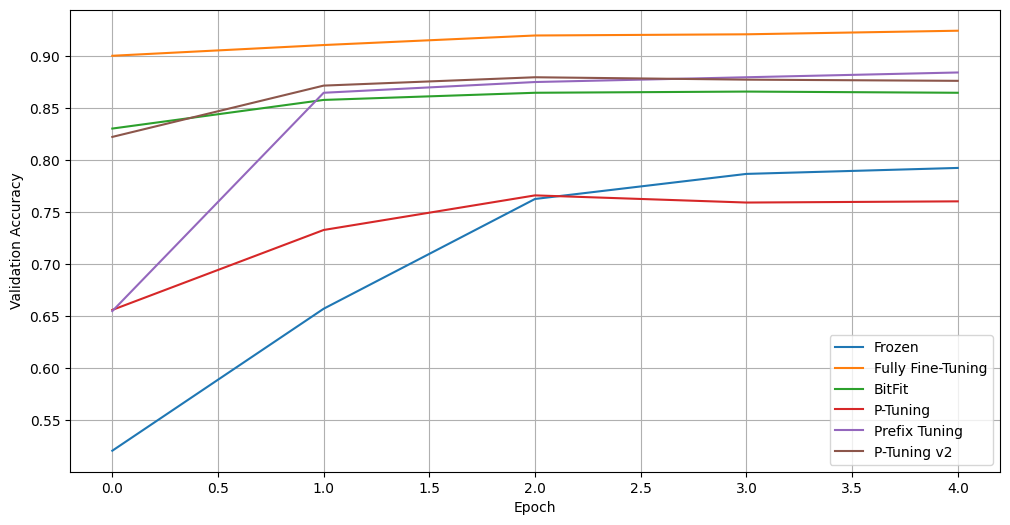

In [38]:
plot_training_record(training_record, metric_name="val_acc")

## LoRA

LoRA（论文：LoRA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS），该方法的核心思想就是通过低秩分解来模拟参数的改变量，从而以极小的参数量来实现大模型的间接训练。

在涉及到矩阵相乘的模块，在原始的PLM旁边增加一个新的通路，通过前后两个矩阵A,B相乘，第一个矩阵A负责降维，第二个矩阵B负责升维，中间层维度为r，从而来模拟所谓的本征秩（intrinsic rank）。

rank的作用：
rank代表低秩矩阵的秩，即线性变换矩阵A和B的输出特征数量。在LoRA中，原始的高维特征通过线性变换A被映射到一个低维空间（rank维），然后再通过另一个线性变换B映射回原始特征空间。较低的rank值意味着更少的参数需要更新，从而降低了模型复杂度和计算成本。

lora_alpha的作用：
lora_alpha是一个缩放因子，用于调整LoRA输出的贡献。它通过除以rank来计算得到scaling，这个缩放因子被用于控制低秩空间中的特征对最终输出的贡献度。较大的lora_alpha值会增加LoRA特征的影响力，而较小的值则会减少其影响。

In [39]:
import torch
import torch.nn as nn
from transformers import AutoModel
# 其他必要的导入语句可能在这里，例如用于训练的优化器、损失函数等。

# 定义LoRALayer类，它继承自PyTorch的nn.Module
class LoRALayer(nn.Module):
    # 初始化函数
    def __init__(self, module: nn.Module, rank: int = 1, lora_alpha: int = 1):
        # 调用父类的初始化函数
        super().__init__()
        # 确保输入的rank是正整数
        assert isinstance(rank, int) and rank > 1, "Lora rank should be a positive integer"

        # 计算缩放因子
        self.scaling = lora_alpha / rank
        # 存储传入的模块
        self.module = module
        # 定义从输入特征到rank维空间的线性变换A
        self.A = nn.Linear(module.in_features, rank, bias=False)
        # 定义从rank维空间到输出特征的线性变换B
        self.B = nn.Linear(rank, module.out_features, bias=False)
        # 使用Kaiming均匀初始化方法初始化A的权重,超参可选
        nn.init.kaiming_uniform_(self.A.weight, a=5 ** 0.5)
        # 将B的权重初始化为0，超参可选
        nn.init.zeros_(self.B.weight)
        # 将A和B移动到与模块权重相同的设备上
        self.A.to(device=module.weight.device)
        self.B.to(device=module.weight.device)

    # 前向传播函数
    def forward(self, inputs, *args, **kwargs):
        # 首先通过原始模块进行前向传播
        with torch.no_grad():  # 确保这个操作不会影响梯度计算
            outputs = self.module(inputs, *args, **kwargs)
        # 计算LoRA的输出并加到原始模块的输出上
        return outputs + self.B(self.A(inputs)) * self.scaling

# 定义LoRABert类，它也继承自PyTorch的nn.Module
class LoRABert(nn.Module):
    # 初始化函数
    def __init__(self, rank=8, lora_alpha=32):
        # 调用父类的初始化函数
        super().__init__()
        # 加载预训练的BERT模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        # 应用LoRA技术到BERT模型的查询投影和键投影
        self._apply_lora(rank=rank, lora_alpha=lora_alpha)
        # 定义一个线性分类器，用于最后的任务分类
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

    # 应用LoRA到BERT模型的辅助函数,把self.model换掉了
    def _apply_lora(self, rank, lora_alpha):
        # 冻结预训练模型的参数
        for param in self.model.parameters():
            param.requires_grad = False
        # 对BERT模型中的每一层应用LoRA，children()可以拿到每层的层对象,也可以换V和O，这就是超参
        for layer in self.model.encoder.layer.children():
            layer.attention.self.query = LoRALayer(layer.attention.self.query, rank=rank, lora_alpha=lora_alpha)
            layer.attention.self.key = LoRALayer(layer.attention.self.key, rank=rank, lora_alpha=lora_alpha)

    # 前向传播函数
    def forward(self, input_ids, attention_mask, token_type_ids):
        # 通过BERT模型进行前向传播
        outputs = self.model(input_ids, attention_mask, token_type_ids)
        # 提取[CLS]标记的表示作为特征
        feature = outputs.last_hidden_state[:, 0, :]
        # 使用分类器生成logits
        logits = self.classifier(feature)
        # 应用sigmoid激活函数得到最终的输出
        return torch.sigmoid(logits).squeeze()

# 实例化LoRABert模型
lora_bert = LoRABert(lora_alpha=32)
print(lora_bert)
# 假设count_parameters是一个函数，用于计算并打印模型的参数数量
count_parameters(lora_bert)



LoRABert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): LoRALayer(
                (module): Linear(in_features=768, out_features=768, bias=True)
                (A): Linear(in_features=768, out_features=8, bias=False)
                (B): Linear(in_features=8, out_features=768, bias=False)
              )
              (key): LoRALayer(
                (module): Linear(in_features=768, out_features=768, bias=True)
                (A): Linear(in_features=768, out_features=8, bias=False)
                (B): 

In [40]:
# 假设train是一个函数，用于训练模型
# training_record是一个字典，用于记录不同模型的训练结果
# train_loader和val_loader是数据加载器，device是指定的设备（CPU或GPU）
# num_epochs是训练的轮数，patience是早停的耐心轮数
training_record["LoRA"] = train(lora_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.6695, train_acc 0.5601, val_loss 0.5472, val_acc 0.7798


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.4187, train_acc 0.8311, val_loss 0.3122, val_acc 0.8739


  0%|          | 0/2105 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
del lora_bert

In [ ]:
plot_training_record(training_record, metric_name="val_acc")

## Adapter Tuning

Adapter Tuning（论文：Parameter-Efficient Transfer Learning for NLP），该方法设计了Adapter结构，并将其嵌入Transformer的结构里面，针对每一个Transformer层，增加了两个Adapter结构(分别是多头注意力的投影之后和第二个feed-forward层之后)，在训练时，固定住原来预训练模型的参数不变，只对新增的 Adapter 结构和 Layer Norm 层进行微调，从而保证了训练的高效性。

In [42]:
class AdapterLayer(nn.Module):
    def __init__(self, input_size, adapter_size):
        super().__init__()
        # 第一个线性层，将输入特征从 input_size 维度降低到 adapter_size 维度
        self.down_project = nn.Linear(input_size, adapter_size)
        # ReLU 激活函数
        self.nolinearity = nn.ReLU()
        # 第二个线性层，将适配器层的特征从 adapter_size 维度恢复到原始维度
        self.up_project = nn.Linear(adapter_size, input_size)

    def forward(self, x):
        # 适配器层的前向传播
        return self.up_project(self.nolinearity(self.down_project(x)))


class BertSelfOutput(nn.Module):
    # 自注意力层的输出部分
    def __init__(self, config, adapter_size):
        super().__init__()
        # 原始的全连接层
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        # 原始的LayerNorm 层
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        # 原始的 Dropout 层
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # 插入的适配器层
        self.adapter = AdapterLayer(config.hidden_size, adapter_size)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        # 自注意力层的输出前向传播
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.adapter(hidden_states) #把自己写的adapter给串进去
        hidden_states = self.LayerNorm(hidden_states + input_tensor) #加号代表残差连接
        return hidden_states

class BertOutput(nn.Module):
    # 输出层
    def __init__(self, config, adapter_size):
        super().__init__()
        # 原始的全连接层
        # print(config.intermediate_size) #3072
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        # LayerNorm 层
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        # Dropout 层
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # 插入的适配器层
        self.adapter = AdapterLayer(config.hidden_size, adapter_size)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        # 输出层的前向传播
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.adapter(hidden_states) #把adapter放入原有的层中间
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class AdapterBert(nn.Module):
    def __init__(self, adapter_size=64):
        super().__init__()
        # 加载预训练的BERT模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        # 获取预训练模型的状态字典，为什么要提前保存，是因为原有的层被覆盖的问题
        pretrained_state_dict = self.model.state_dict()
        print(self.model.config)
        # 添加一个线性分类器
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

        # 为模型的每层应用适配器，把模型对应的BertSelfOutput和BertOutput覆盖
        self._apply_adapter(adapter_size=adapter_size)

        # 修改预训练状态字典，将适配器层的参数加入
        for name, param in self.model.named_parameters():
            if "adapter" in name:
                pretrained_state_dict[name] = param
        # 加载修改后的状态字典
        self.model.load_state_dict(pretrained_state_dict)

        # 冻结除适配器层以外的所有参数
        for name, param in self.model.named_parameters():
            if "adapter" not in name:
                param.requires_grad = False

        # 删除不再使用的预训练状态字典
        del pretrained_state_dict

    def _apply_adapter(self, adapter_size):
        # 为BERT模型的每层应用适配器层
        for layer in self.model.encoder.layer:
            layer.attention.output = BertSelfOutput(self.model.config, adapter_size) #BertSelfOutput输出层重写,名字是完全对应的
            layer.output = BertOutput(self.model.config, adapter_size) #BertOutput层重写，名字是完全对应的

    def forward(self, input_ids, attention_mask, token_type_ids):
        # 模型的前向传播
        outputs = self.model(input_ids, attention_mask, token_type_ids)
        # 提取[CLS]标记的表示作为特征
        feature = outputs.last_hidden_state[:, 0, :]
        # 使用分类器生成logits
        logits = self.classifier(feature)
        # 应用sigmoid激活函数得到最终的输出
        return torch.sigmoid(logits).squeeze()


# 实例化适配器BERT模型
adapter_bert = AdapterBert(adapter_size=64)
print('-'*50)
print(adapter_bert)
print('-'*50)
# 计算模型参数
count_parameters(adapter_bert)



BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

--------------------------------------------------
AdapterBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((76

In [44]:
# 训练模型
training_record["Adapter Tuning"] = train(adapter_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.6167, train_acc 0.6273, val_loss 0.4892, val_acc 0.7752


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.3948, train_acc 0.8217, val_loss 0.4450, val_acc 0.7970


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 2: train_loss 0.3611, train_acc 0.8399, val_loss 0.4319, val_acc 0.8028


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 3: train_loss 0.3458, train_acc 0.8488, val_loss 0.4262, val_acc 0.8039


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 4: train_loss 0.3390, train_acc 0.8529, val_loss 0.4246, val_acc 0.8062


In [ ]:
del adapter_bert

## Plot

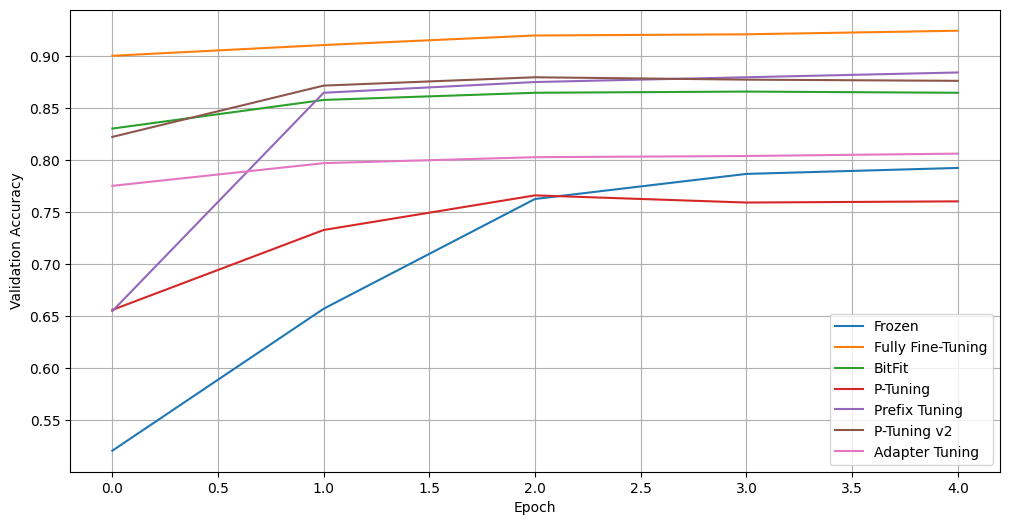

In [45]:

plot_training_record(training_record, metric_name="val_acc")